# Test mit den Modellen einzeln

### Imports

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from matplotlib import pyplot as plt
import tensorflow as tf
import logging
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score
import pandas as pd
import os
import sys
import logging
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

2025-08-29 14:50:58.210829: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Logs laden

In [2]:
data_train = pd.read_json("train_logs.jsonl", lines=True)
data_test = pd.read_json("test_logs.jsonl", lines=True)
data_val = pd.read_json("val_logs.jsonl", lines=True)

In [3]:
X_train_full = pd.DataFrame(data_train)
X_test_full = pd.DataFrame(data_test)
X_val_full = pd.DataFrame(data_val)
y_test_full = data_test["label"]
y_val_full = data_val["label"]

### Daten in numerisch/kategorisch unterteilen

In [4]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def is_missing(val):
    return val is None or (isinstance(val, float) and np.isnan(val))

def flatten_log_entry(log, parent_key='', sep='.'):
    items = []
    for k, v in log.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_log_entry(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


def auto_encode_features(logs, one_hot_numeric=False, label_encoders=None, onehot_encoders=None, fit=True):
    # Zuerst alle Logs flach machen:
    flat_logs = [flatten_log_entry(log) for log in logs]

    # dann wie gehabt mit flachen Logs weiterarbeiten:
    # Beispiel:
    if label_encoders is None:
        label_encoders = {}
    if onehot_encoders is None:
        onehot_encoders = {}

    # Jetzt für jeden Key alle möglichen Werte bestimmen und LabelEncoder fitten
    for key in flat_logs[0].keys():
        # Werte aller Logs für dieses Feature sammeln
        values = [log.get(key) if log.get(key) is not None else "__MISSING__" for log in flat_logs]

        # Je nachdem ob es numerisch ist oder nicht (hier als Beispiel alles kategorisch)
        if fit:
            le = LabelEncoder()
            le.fit(values)
            label_encoders[key] = le

    # Features dann kodieren (für Train und Test)
    encoded_logs = []
    for log in flat_logs:
        encoded_log = {}
        for key, le in label_encoders.items():
            val = log.get(key, "__MISSING__")
            # Fallback falls Wert nicht bekannt (z.B. im Test)
            try:
                encoded_log[key] = le.transform([val])[0]
            except ValueError:
                encoded_log[key] = -1  # unbekannte Kategorie
        encoded_logs.append(encoded_log)

    return encoded_logs, label_encoders, onehot_encoders


### Zusammenfügen

In [5]:
def dicts_to_feature_matrix(encoded_logs):
    feature_names = sorted({key for d in encoded_logs for key in d.keys()})

    X = np.zeros((len(encoded_logs), len(feature_names)), dtype=np.float32)

    for i, d in enumerate(encoded_logs):
        for j, feat in enumerate(feature_names):
            if feat in d:
                X[i, j] = d[feat]

    return X, feature_names

### Daten unterteilen

In [6]:
logs_train = X_train_full.to_dict(orient='records')
#logs_train = events
logs_test = X_test_full.to_dict(orient='records')
logs_val = X_val_full.to_dict(orient='records')

encoded_logs, label_encoders, onehot_encoders = auto_encode_features(
    logs_train, one_hot_numeric=False, fit=True
)
X_train, feature_names = dicts_to_feature_matrix(encoded_logs)

encoded_test_logs, _, _ = auto_encode_features(
    logs_test, one_hot_numeric=False,
    label_encoders=label_encoders, onehot_encoders=onehot_encoders, fit=False
)
X_test, _ = dicts_to_feature_matrix(encoded_test_logs)

encoded_val_logs, _, _ = auto_encode_features(
    logs_val, one_hot_numeric=False,
    label_encoders=label_encoders, onehot_encoders=onehot_encoders, fit=False
)
X_val, _ = dicts_to_feature_matrix(encoded_val_logs)

### Skalieren

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

### Test mit IF

In [ ]:
iforest = IsolationForest(random_state=42, contamination=0.0008, max_samples = 'auto')
iforest.fit(X_train_scaled)

test_scores = iforest.decision_function(X_test_scaled)
test_preds = iforest.predict(X_test_scaled)
y_test_pred = (test_preds == -1).astype(int)
#logging.info("Test Classification Report:\n" + classification_report(y_test_full, y_test_pred))
print("Test Classification Report:\n" + classification_report(y_test_full, y_test_pred))

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5850
           1       1.00      0.10      0.18        31

    accuracy                           1.00      5881
   macro avg       1.00      0.55      0.59      5881
weighted avg       1.00      1.00      0.99      5881



### Test IF MCC

In [21]:
mcc = matthews_corrcoef(y_test_full, y_test_pred)
#logging.info("Matthews Correlation Coefficient: %f", mcc)
print("Matthews Correlation Coefficient: %f", mcc)

Matthews Correlation Coefficient: %f 0.3103436921499152


### Test IF Balanced Accuracy

In [10]:
balanced_acc = balanced_accuracy_score(y_test_full, y_test_pred)
#logging.info("Balanced Accuracy: %f", balanced_acc)
print("Balanced Accuracy: %f", balanced_acc)

Balanced Accuracy: %f 0.5483870967741935


### Test IF AUC-Kurven

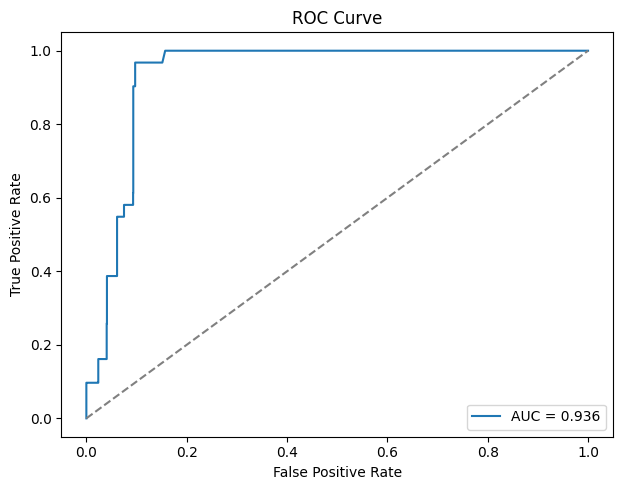

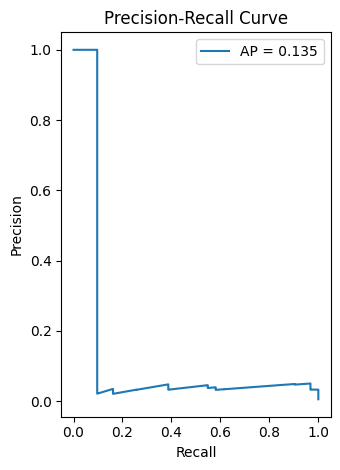

In [11]:
# Anomaly Scores invertieren (höher = anomal)
anomaly_scores = -test_scores

# ROC-Kurve und AUC
fpr, tpr, _ = roc_curve(y_test_full, anomaly_scores)
roc_auc = roc_auc_score(y_test_full, anomaly_scores)

# Precision-Recall-Kurve und Average Precision (PR AUC)
precision, recall, _ = precision_recall_curve(y_test_full, anomaly_scores)
pr_auc = average_precision_score(y_test_full, anomaly_scores)

# Plot ROC Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

### Test DBSCAN 

In [23]:
for eps in np.linspace(0.01, 1.0, 100):
    dbscan = DBSCAN(min_samples=3, metric='euclidean', eps=eps)
    labels = dbscan.fit_predict(X_test_scaled)
    n_anomalies = np.sum(labels == -1)
    if abs(n_anomalies - 31) <= 2:
        print(f'Passender eps-Wert: {eps}, Anomalien: {n_anomalies}')
        break

y_pred = np.where(labels == -1, 1, 0)
print("Test Classification Report:\n" + classification_report(y_test_full, y_pred))

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5850
           1       0.90      0.29      0.44        31

    accuracy                           1.00      5881
   macro avg       0.95      0.65      0.72      5881
weighted avg       1.00      1.00      1.00      5881



### Test DBSCAN MCC

In [14]:
# mcc = matthews_corrcoef(y_test_full, dbscan_anomaly_test)
# #logging.info("Matthews Correlation Coefficient: %f", mcc)
# print("Matthews Correlation Coefficient: %f", mcc)

### Test DBSCAN Balanced Accuracy

In [15]:
# balanced_acc = balanced_accuracy_score(y_test_full, dbscan_anomaly_test)
# #logging.info("Balanced Accuracy: %f", balanced_acc)
# print("Balanced Accuracy: %f", balanced_acc)

### Test DBSCAN AUC-Kurven

In [16]:
# # Dummy-Scores: Anomalie = 1.0, Normal = 0.0 (nicht ideal!)
# anomaly_scores = (dbscan_labels_test == -1).astype(float)

# fpr, tpr, _ = roc_curve(y_test_full, anomaly_scores)
# roc_auc = roc_auc_score(y_test_full, anomaly_scores)

# precision, recall, _ = precision_recall_curve(y_test_full, anomaly_scores)
# pr_auc = average_precision_score(y_test_full, anomaly_scores)

# # Plotten
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
# plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.tight_layout()
# plt.show()

# plt.subplot(1, 2, 2)
# plt.plot(recall, precision, label=f"AP = {pr_auc:.3f}")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")
# plt.legend()
# plt.tight_layout()
# plt.show()

### Test OCSVM

In [17]:
ocsvm = OneClassSVM(nu = 0.0008, gamma='scale', kernel = 'rbf')
ocsvm.fit(X_train_scaled)

y_pred_test_oc = ocsvm.predict(X_test_scaled)
anomaly_test = (y_pred_test_oc == -1).astype(int)
#logging.info("Test Report:\n" + classification_report(y_test_full, anomaly_test))
print("Test Report:\n" + classification_report(y_test_full, anomaly_test))

Test Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      5850
           1       0.03      1.00      0.06        31

    accuracy                           0.83      5881
   macro avg       0.52      0.92      0.48      5881
weighted avg       0.99      0.83      0.90      5881



### OCSVM MCC

In [18]:
mcc = matthews_corrcoef(y_test_full, anomaly_test)
#logging.info("Matthews Correlation Coefficient: %f", mcc)
print("Matthews Correlation Coefficient: %f", mcc)

Matthews Correlation Coefficient: %f 0.1602474891741323


### OCSVM Balanced Accuracy

In [19]:
balanced_acc = balanced_accuracy_score(y_test_full, anomaly_test)
#logging.info("Balanced Accuracy: %f", balanced_acc)
print("Balanced Accuracy: %f", balanced_acc)

Balanced Accuracy: %f 0.9166666666666667


### OCSVM AUC-Kurven

In [ ]:
# Score: Decision Function (negiert für "mehr Anomalie = höherer Score")
scores = -ocsvm.decision_function(X_test_scaled)

# ROC
fpr, tpr, _ = roc_curve(y_test_full, scores)
roc_auc = roc_auc_score(y_test_full, scores)

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test_full, scores)
pr_auc = average_precision_score(y_test_full, scores)

# Plotten
plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# PR
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()